# Anchored CoreX on STS Benchmark dataset

### Requirements

In [1]:
import numpy as np
import scipy.sparse as ss
import pandas as pd
import pickle

from corextopic import corextopic as ct
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib import pyplot as plt

from sentence_similarity.data import Pipeline, PipelineConfig, STSBenchmark

data_dir = Path("data")
assert data_dir.exists(), "data_dir does not exist."
output_dir = Path("data")
output_dir.mkdir(exist_ok=True, parents=True)

## Preprocessing & Vectorizer

In [2]:
config = PipelineConfig(
    filtered_pos_tags=[],
    remove_stop_words=True,
    remove_numbers=False,
    remove_symbols=False,
    remove_punctuation=False,
)
pipeline = Pipeline(config)
config.save(data_dir)

In [3]:
# load the dataset
sts_benchmark = STSBenchmark(data_dir, partition="train")

In [4]:
# preprocess sentences
s1_preprocessed = pipeline(sts_benchmark.s1)
s2_preprocessed = pipeline(sts_benchmark.s2)

Preprocessing: 100%|██████████| 5552/5552 [00:02<00:00, 1947.40it/s]


In [5]:
pd.concat([sts_benchmark.s1, s1_preprocessed], axis=1)

,s1,0
0,A plane is taking off.,plane take .
1,A man is playing a large flute.,man play large flute.
2,A man is spreading shreded cheese on a pizza.,man spread shred cheese pizza.
3,Three men are playing chess.,man play chess.
4,A man is playing the cello.,man play cello.
...,...,...
5547,"Palestinian hunger striker, Israel reach deal","palestinian hunger striker, Israel reach deal"
5548,Assad says Syria will comply with UN arms reso...,Assad say Syria comply UN arm resolution
5549,South Korean President Sorry For Ferry Response,south korean President sorry Ferry Response
5550,Food price hikes raise concerns in Iran,food price hike raise concern Iran


In [6]:
# fit TF-IDF vectorizer
vectorizer = TfidfVectorizer(strip_accents="ascii", binary=True, ngram_range=(1,1))
doc_word = vectorizer.fit_transform(pd.concat([s1_preprocessed, s2_preprocessed]))
doc_word = ss.csr_matrix(doc_word)

# save vectorizer
with open(output_dir / "vectorizer.bin", "wb") as f:
    pickle.dump(vectorizer, f)

print(doc_word.shape)  # n_docs x m_words

# Get words that label the columns (needed to extract readable topics and make anchoring easier)
words = list(np.asarray(vectorizer.get_feature_names_out()))
print("# digits:", len([word for word in words if word.isdigit()]))

(11104, 9393)
# digits: 360


## CoreX Topic model

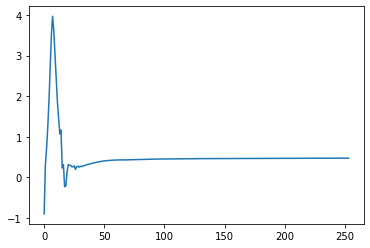

In [7]:
# Train the CorEx topic model with 50 topics
topic_model = ct.Corex(n_hidden=50, words=words, max_iter=300, seed=1)
topic_model.fit(doc_word, words=words)

plt.plot(topic_model.tc_history)
plt.show()

In [8]:
topic_model.save(output_dir / "corex_model.bin")

In [9]:
# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))

0: dog, white, black, ride, run, sit, horse, brown, stand, snow
1: percent, stock, index, cent, share, nasdaq, point, composite, standard, high
2: san, birthday, suu, murdoch, kyi, lessing, doris, aung, frank, equal
3: king, asylum, universe, explanation, monteith, cory, margaret, thatcher, self, tendulkar
4: wonder, vessel, fill, plead, guilty, fraud, false, bail, cholesterol, whitey
5: slice, onion, cut, woman, potato, peel, meat, tomato, chop, pan
6: nuclear, korea, north, program, proliferation, united, peaceful, weapon, international, states
7: kill, drone, pakistan, soldier, afghanistan, suicide, bomb, attack, afghan, militant
8: post, originally, buy, common, hi, sense, lustig, andrei, pregnancy, crossword
9: opinion, bin, illness, sistan, baluchestan, laden, 7th, osama, matter, wimbledon
10: play, guitar, flute, man, piano, keyboard, singe, drum, singing, violin
11: quake, magnitude, usgs, beckham, retire, jolt, cenc, tel, aviv, tsunami
12: treaty, amend, ratify, cfe, conventio